# Autoencoder Fashion-MNIST

## Configuraciones del sistema

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!ls drive
#!ls
#!mkdir drive/MyDrive/saved_models

Primero chequeamos si hay disponibles placas GPU con CUDA, o no.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cuda


## Configración de Hiperparámetros

In [5]:
hide_layer = 64

In [6]:
_learning_rate = 1e-3
_batch_size = 1000
_epochs = 200

## Modelo NN

Luego, definimos nuestro modelo como una clase derivada de la clase `nn.Module`.
Inicializamos la red neuronal usando el metodo`.__init__()`.
Toda subclase de `nn.Module` implementa el como operar sobre datos de entrada (input) para generar una salida (output) a travéz del método `.forward()`.
Por otro lado, notar que NO implementamos el método `.backward()`.

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Primero convertimos los datos de entrada a un gran vector.
        self.flatten = nn.Flatten()
        # Luego generamos una secuencia de transformaciones que implementan las capas de la red.
        # Algunas capas consisten en transformaciones lineales, que incluyen parámetros.
        # Otras consisten en funciones de activación no lineales (en este caso de tipo ReLU), que no incluyen parámetros.
        # Los tamaños de las capas se especifican a travez de los tamaños de las transformaciones lineales.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, hide_layer),
            #nn.ReLU(),
            #nn.Linear(hide_layer, hide_layer),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hide_layer, 28*28),
        )

    def forward(self, x):
        # Este método es usado internamente para transformar inputs en outputs en las fases forward.
        # Al igual que antes, aplanamos los datos de entrada en un gran vector.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Luego creamos una un objeto (o instancia) de la clase `NeuralNetwork`, y lo movemos al dispositivo que usaremos.
Además, imprimimos su estructura para ver inspeccionar.

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=784, bias=True)
  )
)


## Dataset

Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

subclase que modifica el dataset a negativo

In [10]:
class CustomImageDatasetModif(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        image = torch.add(torch.neg(image),1)
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

Ahora, veamos como entrenar el modelo con el dataset *FashionMNIST*.

https://github.com/zalandoresearch/fashion-mnist

Este dataset se implementa en términos de las clases `Dataset` y `DataLoader` proveidas por PyTorch.
Respecitivamente, estas clases se usan para cargar y muestrear conjuntos de datos de formas convenientes y compatibles con PyTorch.

Comenzamos por cargar el dataset de entrenamiento y el dataset de validación.

In [11]:
# La primera vez esto tarda un rato ya que tiene que bajar los datos de la red.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [12]:
my_train_ds = CustomImageDataset(training_data)
#my_test_ds = CustomImageDatasetModif(test_data)
my_test_ds = CustomImageDataset(test_data)

Generemos ahora instancias de la clase `DataLoader` para estos objetos derivados de la clase `DataSet`.

### Carga de datos

In [13]:
train_dataloader = DataLoader(
    my_train_ds, 
    batch_size=_batch_size,
    shuffle=True)
test_dataloader = DataLoader(
    my_test_ds, 
    batch_size=_batch_size,
    shuffle=True)

## Entrenamiento

Ya estamos en condiciones de implementar el entrenador del modelo.

In [14]:
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimimos el progreso...
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    return loss.item()

# De manera similar, definimos la función de validación
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    

    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X, y in dataloader:
            # Calculamos las predicciones del modelo...
            pred = model(X.to(device))
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            test_loss += loss_fn(pred, y.to(device)).item()

    # Calculamos la pérdida total y las imprimimos.
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    return test_loss

In [15]:
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# y un optimizador, un Stochastic Gradient Descent, en este caso.
optimizer = torch.optim.Adam(model.parameters(), lr=_learning_rate)

In [16]:
print('train: ', len(train_dataloader.dataset))
print('test: ', len(test_dataloader.dataset))

train:  60000
test:  10000


In [17]:
%%time
# Iterando sobre épocas

train_ds_loss = []
test_ds_loss = []

train_ds_loss.append(test_loop(train_dataloader, model, loss_fn.to(device)))
test_ds_loss.append(test_loop(test_dataloader, model, loss_fn.to(device)))

for t in range(_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn.to(device), optimizer)
    test_ds_loss.append(test_loop(test_dataloader, model, loss_fn.to(device)))
    train_ds_loss.append(test_loop(train_dataloader, model, loss_fn.to(device)))

print("Done!")

Test Error: Avg loss: 0.224791 

Test Error: Avg loss: 0.224869 

Epoch 1
-------------------------------
batch=0 loss=0.229873  muestras-procesadas:[    0/60000]
batch=10 loss=0.162800  muestras-procesadas:[10000/60000]
batch=20 loss=0.109884  muestras-procesadas:[20000/60000]
batch=30 loss=0.081507  muestras-procesadas:[30000/60000]
batch=40 loss=0.072092  muestras-procesadas:[40000/60000]
batch=50 loss=0.064835  muestras-procesadas:[50000/60000]
Test Error: Avg loss: 0.053935 

Test Error: Avg loss: 0.054178 

Epoch 2
-------------------------------
batch=0 loss=0.061317  muestras-procesadas:[    0/60000]
batch=10 loss=0.056133  muestras-procesadas:[10000/60000]
batch=20 loss=0.054104  muestras-procesadas:[20000/60000]
batch=30 loss=0.053106  muestras-procesadas:[30000/60000]
batch=40 loss=0.049226  muestras-procesadas:[40000/60000]
batch=50 loss=0.048164  muestras-procesadas:[50000/60000]
Test Error: Avg loss: 0.040600 

Test Error: Avg loss: 0.040781 

Epoch 3
--------------------

## Resultados

### Guarda

In [18]:
train_ds = pd.DataFrame(train_ds_loss, columns=['train'])
test_ds = pd.DataFrame(test_ds_loss, columns=['test'])
ds = train_ds.join(test_ds)
ds.to_csv("/content/drive/MyDrive/saved_models/loss_ds_hl{}_ep200_btch1000_Adam.csv".format(hide_layer))
ds

train      test
0    0.224791  0.224869
1    0.054178  0.053935
2    0.040781  0.040600
3    0.033656  0.033526
4    0.030096  0.029987
..        ...       ...
196  0.016882  0.016916
197  0.016944  0.016981
198  0.016999  0.017033
199  0.016902  0.016934
200  0.016980  0.017015

[201 rows x 2 columns]

In [19]:
torch.save(model.state_dict(), "/content/drive/MyDrive/saved_models/model_hl{}_ep200_btch1000_Adam.pt".format(hide_layer))

In [20]:
#model = NeuralNetwork().to(device)
#model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/model_hl{}_ep200_btch1000_Adam.pt".format(hide_layer)))  # /content/drive/MyDrive/models/

### Muestra

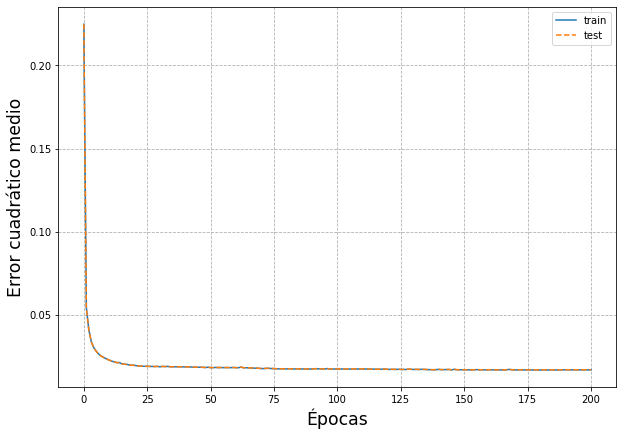

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(train_ds_loss, '-', label='train')
plt.plot(test_ds_loss, '--', label='test')
plt.legend()
#plt.ylim(0, 0.4)
plt.xlabel('Épocas', fontsize='xx-large')
plt.ylabel('Error cuadrático medio', fontsize='xx-large')
plt.grid(ls='--')
plt.show()

#print(train_ds_loss)
#ds 

imagen.shape=torch.Size([1, 28, 28])
test id: 6066


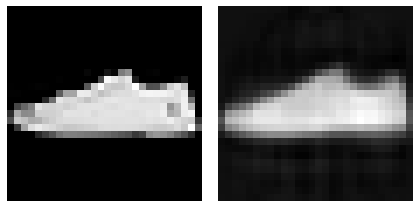

In [22]:
# Elegimos una imagen y calculamos la correspondiente prediccion generada por el modelo.
model.eval()
sample_idx = torch.randint(len(my_test_ds),size=(1,)).item()
imagen,label = my_test_ds[sample_idx]
print(f"imagen.shape={imagen.shape}")
print('test id: {}'.format(sample_idx))
imagen_gpu = imagen.to(device)
pred_gpu = model(imagen_gpu)
pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)) # Pasamos la predección a la CPU y le damos el formato de una imagen de 28x28 píxeles.

# Ploteamos una imagen y la correspondiente generada por el modelo.
fig,axes=plt.subplots(1,2)
fig.set_size_inches(6,3)
ax = axes[0]
ax.axis("off")
ax.imshow(imagen.squeeze(),cmap="gray")
ax = axes[1]
ax.axis("off")
ax.imshow(pred_cpu.squeeze(),cmap="gray")
fig.tight_layout()
plt.show()